<h1> Question 3

<h3> <b> Part 1

In [1]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import csv
from tqdm import tqdm

class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir, class_dict_path, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        # Read all image filenames
        self.image_names = sorted(os.listdir(images_dir))
        
        # If mask filenames match, we can just do the same
        self.mask_names = sorted(os.listdir(masks_dir))
        
        # Make color->classID mapping
        self.color2class = self.load_class_dict(class_dict_path)
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        # Paths
        img_path = os.path.join(self.images_dir, self.image_names[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_names[idx])
        
        # Open images
        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(mask_path).convert("RGB")  # color-coded labels
        
        # Resize both image & mask

        image = image.resize((480, 360), Image.BILINEAR) 
        mask  = mask.resize((480, 360), Image.NEAREST)

                
        
        
        # Convert mask from color-coded to a 2D class index array
        mask_array = np.array(mask)       
        mask_index = self.rgb2class(mask_array)  
        
        # Convert image to tensor
        image_tensor = F.to_tensor(image) # shape [3, 360, 480], float in [0,1]
        
        # Normalize the image
        # mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        image_tensor = F.normalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        # Convert mask_index to torch long tensor
        mask_tensor = torch.from_numpy(mask_index).long()  # shape [360,480]
        
        return image_tensor, mask_tensor
    
    def load_class_dict(self, class_dict_path):
        """
        Reads class_dict.csv and returns a dict { (r,g,b): class_id, ... }.
        """
        color2class = {}
        with open(class_dict_path, 'r') as f:
            reader = csv.DictReader(f, delimiter='\t') if '\t' in f.read() else csv.DictReader(open(class_dict_path,'r'))
            f.seek(0)
            # The CSV might have a header: name, r, g, b
            # We'll build an index in the order we encounter them
            idx = 0
            for row in reader:
                # Some CSVs might be separated by commas, 
                # so adapt your code as needed:
                r = int(row['r'])
                g = int(row['g'])
                b = int(row['b'])
                color2class[(r,g,b)] = idx
                idx += 1
        return color2class
    
    def rgb2class(self, mask_arr):
        """
        mask_arr: [H,W,3] with color-coded labels
        Return:   [H,W] with class indices
        """
        h, w, _ = mask_arr.shape
        out = np.zeros((h,w), dtype=np.uint8)
        
        for i in range(h):
            for j in range(w):
                rgb = tuple(mask_arr[i,j])
                if rgb in self.color2class:
                    out[i,j] = self.color2class[rgb]
                else:
                    # If we get a color not in dict, treat as 'Void' or background
                    out[i,j] = self.color2class.get((0,0,0), 0)
        return out


In [2]:
from torch.utils.data import DataLoader

train_images_dir = "CamVid/CamVid/train" 
train_masks_dir  = "CamVid/CamVid/train_labels"
class_dict_path  = "CamVid/CamVid/class_dict.csv"

train_dataset = CamVidDataset(train_images_dir, train_masks_dir, class_dict_path)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

test_dataset = CamVidDataset(
    images_dir="CamVid/CamVid/test_images",
    masks_dir="CamVid/CamVid/test_labels",
    class_dict_path="CamVid/CamVid/class_dict.csv"
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

In [3]:
import numpy as np
from collections import Counter
from tqdm import tqdm
pixel_counts = Counter()
total_pixels = 0

for img, mask in tqdm(train_loader):
    # mask shape [B, H, W], each pixel is an integer class index
    mask_np = mask.numpy()  # shape [B, H, W]
    flat = mask_np.ravel()  # all pixels
    pixel_counts.update(flat.tolist())
    total_pixels += flat.size

print("Total pixels in entire train set (just from these batches so far):", total_pixels)
for class_idx, count in tqdm(pixel_counts.items()):
    print(f"Class {class_idx}: {count} pixels ({count/total_pixels*100:.2f}%)")


100%|██████████| 93/93 [04:54<00:00,  3.17s/it]


Total pixels in entire train set (just from these batches so far): 63763200


100%|██████████| 30/30 [00:00<00:00, 137819.41it/s]

Class 30: 1674091 pixels (2.63%)
Class 4: 14535123 pixels (22.80%)
Class 21: 9622689 pixels (15.09%)
Class 8: 659320 pixels (1.03%)
Class 12: 418107 pixels (0.66%)
Class 20: 82724 pixels (0.13%)
Class 16: 394959 pixels (0.62%)
Class 5: 1988559 pixels (3.12%)
Class 10: 1192695 pixels (1.87%)
Class 19: 4351580 pixels (6.82%)
Class 14: 299023 pixels (0.47%)
Class 17: 18245204 pixels (28.61%)
Class 26: 6446861 pixels (10.11%)
Class 24: 231077 pixels (0.36%)
Class 9: 1066638 pixels (1.67%)
Class 2: 301384 pixels (0.47%)
Class 27: 119212 pixels (0.19%)
Class 1: 29897 pixels (0.05%)
Class 7: 19978 pixels (0.03%)
Class 31: 785372 pixels (1.23%)
Class 6: 16511 pixels (0.03%)
Class 15: 224660 pixels (0.35%)
Class 0: 3014 pixels (0.00%)
Class 29: 522217 pixels (0.82%)
Class 18: 155107 pixels (0.24%)
Class 22: 337132 pixels (0.53%)
Class 23: 2466 pixels (0.00%)
Class 3: 26937 pixels (0.04%)
Class 13: 3520 pixels (0.01%)
Class 11: 7143 pixels (0.01%)


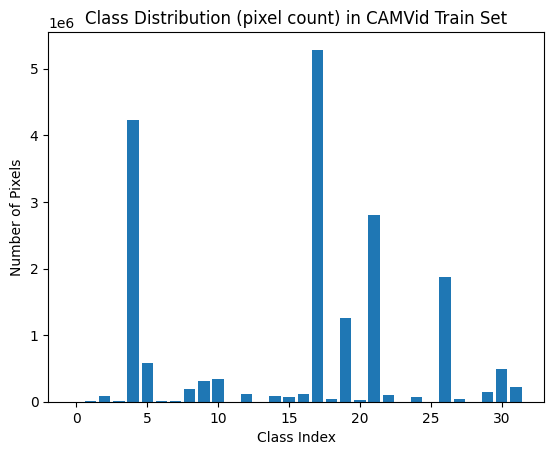

In [4]:
import matplotlib.pyplot as plt

classes = list(pixel_counts.keys())
counts = [pixel_counts[c] for c in classes]

plt.bar(classes, counts)
plt.xlabel("Class Index")
plt.ylabel("Number of Pixels")
plt.title("Class Distribution (pixel count) in CAMVid Train Set")
plt.show()


<b> <i> (c)

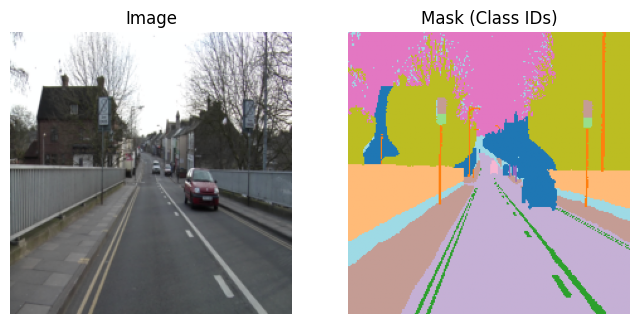

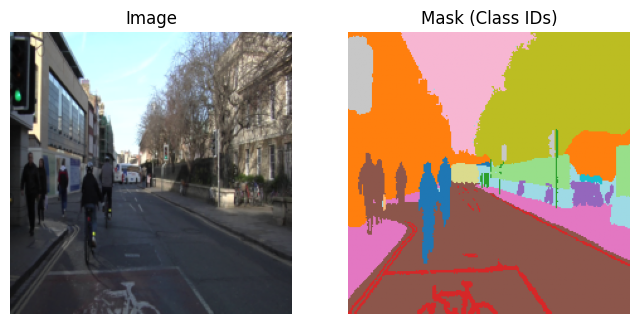

In [5]:
import matplotlib.pyplot as plt

def visualize_sample(dataset, idx):
    # dataset[idx] returns (image_tensor, mask_tensor)
    image_tensor, mask_tensor = dataset[idx]
    
    # image_tensor shape: [3, H, W], masked in [-1..1 or 0..1], normalized
    # We'll un-normalize for display:
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    
    image_np = image_tensor.permute(1,2,0).numpy()  # shape [H,W,3]
    image_np = (image_np * std) + mean
    image_np = np.clip(image_np, 0, 1)
    
    mask_np = mask_tensor.numpy()  # shape [H,W], class indices

    # Plot side-by-side
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    ax1.imshow(image_np)
    ax1.set_title("Image")
    ax1.axis("off")
    
    ax2.imshow(mask_np, cmap='tab20')  
    # or use a custom color map if you prefer matching the class_dict colors
    ax2.set_title("Mask (Class IDs)")
    ax2.axis("off")
    plt.show()

# Visualize 2 random samples
import random
for _ in range(2):
    rand_idx = random.randint(0, len(train_dataset)-1)
    visualize_sample(train_dataset, rand_idx)


<b> <h3> Part 2

<b> <i> (a)

In [3]:
import sys
sys.path.append("Segmentation")
from model_class import *

import torch
import wandb
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [4]:
import torchvision.transforms.functional as F
def train_segnet(train_loader, encoder_weights_path, num_epochs=50):
    wandb.init(project="segnet-training", name="segnet-decoder-training")
    
    model = SegNet_Pretrained(encoder_weights_path, in_chn=3, out_chn=len(train_loader.dataset.color2class))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.decoder.parameters())
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_accuracy = 0
        
        # Create progress bar for each epoch
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            try:
                output = model(data)
                
                if output.shape[2:] != target.shape[1:]:
                    output = F.interpolate(output, size=target.shape[1:], mode='bilinear', align_corners=True)
                
                loss = criterion(output, target)
                accuracy = output.argmax(dim=1).eq(target).float().mean().item() * 100
                
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                total_accuracy += accuracy
                
                # Update progress bar description
                progress_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'accuracy': f'{accuracy:.2f}%'
                })
                
                # Log metrics to wandb every 10 batches
                if batch_idx % 10 == 0:
                    wandb.log({
                        "batch_loss": loss.item(),
                        "batch_accuracy": accuracy,
                        "epoch": epoch,
                        "batch": batch_idx
                    })
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue
            
        # Calculate epoch metrics
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_accuracy / len(train_loader)
        
        # Log epoch metrics
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_loss,
            "train_accuracy": avg_accuracy
        })
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.2f}%")
    
    wandb.finish()
    return model

In [5]:
encoder_weights_path = "Segmentation/encoder_model.pth"
trained_model = train_segnet(train_loader, encoder_weights_path, 10)


wandb: Currently logged in as: kartikeydhaka (kartikey_dhaka) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 1/10: 100%|██████████| 93/93 [00:46<00:00,  2.02it/s, loss=0.6373, accuracy=85.47%]


Epoch 1/10 - Average Loss: 1.1698, Average Accuracy: 69.23%


Epoch 2/10: 100%|██████████| 93/93 [00:46<00:00,  2.02it/s, loss=0.7223, accuracy=79.24%]


Epoch 2/10 - Average Loss: 0.8079, Average Accuracy: 77.97%


Epoch 3/10: 100%|██████████| 93/93 [00:45<00:00,  2.03it/s, loss=0.6738, accuracy=80.84%]


Epoch 3/10 - Average Loss: 0.7175, Average Accuracy: 80.46%


Epoch 4/10: 100%|██████████| 93/93 [00:45<00:00,  2.03it/s, loss=0.7056, accuracy=82.49%]


Epoch 4/10 - Average Loss: 0.6663, Average Accuracy: 81.65%


Epoch 5/10: 100%|██████████| 93/93 [00:45<00:00,  2.04it/s, loss=0.8497, accuracy=73.22%]


Epoch 5/10 - Average Loss: 0.6350, Average Accuracy: 82.32%


Epoch 6/10: 100%|██████████| 93/93 [00:45<00:00,  2.04it/s, loss=0.5695, accuracy=84.08%]


Epoch 6/10 - Average Loss: 0.6086, Average Accuracy: 82.94%


Epoch 7/10: 100%|██████████| 93/93 [00:45<00:00,  2.03it/s, loss=0.4685, accuracy=85.14%]


Epoch 7/10 - Average Loss: 0.5629, Average Accuracy: 84.09%


Epoch 8/10: 100%|██████████| 93/93 [00:45<00:00,  2.04it/s, loss=0.4280, accuracy=88.03%]


Epoch 8/10 - Average Loss: 0.5380, Average Accuracy: 84.68%


Epoch 9/10: 100%|██████████| 93/93 [00:45<00:00,  2.02it/s, loss=0.3229, accuracy=92.65%]


Epoch 9/10 - Average Loss: 0.5077, Average Accuracy: 85.38%


Epoch 10/10: 100%|██████████| 93/93 [00:45<00:00,  2.03it/s, loss=0.3484, accuracy=90.91%]

Epoch 10/10 - Average Loss: 0.4894, Average Accuracy: 85.78%


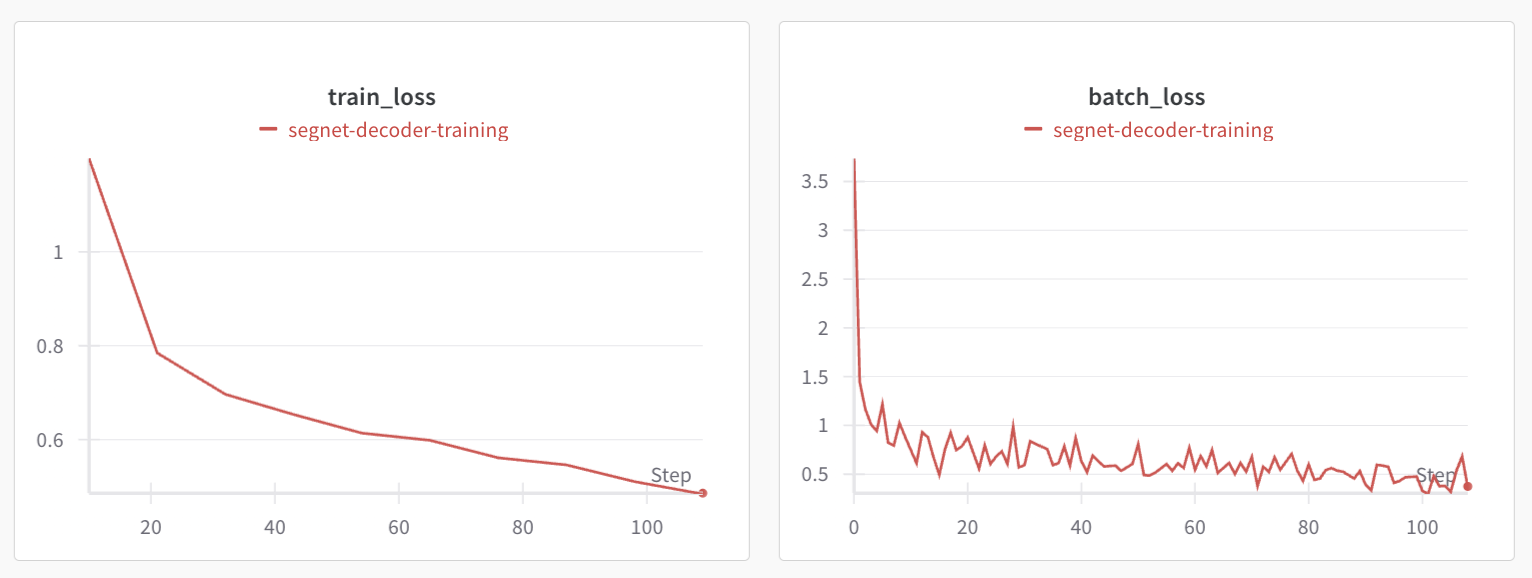

<b> <i> (b)

In [8]:
import torch
import numpy as np

trained_model.eval()
all_preds = []
all_targets = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = trained_model(images) # shape [B, num_classes, H, W]
        preds  = torch.argmax(outputs, dim=1) # shape [B, H, W]
        
        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

# Concatenate everything
all_preds = np.concatenate(all_preds, axis=0)   # shape [N, H, W]
all_targets = np.concatenate(all_targets, axis=0) # shape [N, H, W]


100%|██████████| 58/58 [00:28<00:00,  2.00it/s]


In [9]:
def compute_confusion_matrix(preds, labels, num_classes):
    """
    preds, labels: shape [N, H, W]
    Returns: a confusion matrix of shape [num_classes, 2, 2] or a single matrix [num_classes, num_classes].
    Here, we’ll do a simpler: a single [num_classes, num_classes] matrix,
    where matrix[i,j] = #pixels that belong to class i (GT) but predicted as class j.
    """
    mask = (labels >= 0) & (labels < num_classes)
    hist = np.bincount(
        num_classes * labels[mask].astype(int) + preds[mask],
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes)
    return hist

num_classes = 32 # e.g. for CAMVid, if you have 32 classes
conf_mat = np.zeros((num_classes, num_classes), dtype=np.int64)

# Build the matrix
conf_mat += compute_confusion_matrix(all_preds, all_targets, num_classes=num_classes)


In [10]:
def compute_metrics_from_confmat(conf_mat):
    """
    conf_mat: shape [num_classes, num_classes]
    Returns a dict with classwise iou, dice, precision, recall, etc.
    """
    num_classes = conf_mat.shape[0]
    class_iou   = np.zeros(num_classes)
    class_dice  = np.zeros(num_classes)
    class_prec  = np.zeros(num_classes)
    class_recall= np.zeros(num_classes)
    
    for c in range(num_classes):
        TP = conf_mat[c,c]
        FN = conf_mat[c,:].sum() - TP
        FP = conf_mat[:,c].sum() - TP
        # TN = conf_mat.sum() - (TP+FN+FP)  # Not always needed

        denom_iou = (TP + FP + FN)
        if denom_iou == 0:
            class_iou[c] = np.nan
        else:
            class_iou[c] = TP / denom_iou
        
        denom_dice = (2*TP + FP + FN)
        if denom_dice == 0:
            class_dice[c] = np.nan
        else:
            class_dice[c] = (2*TP) / denom_dice

        denom_prec = (TP+FP)
        class_prec[c] = TP/denom_prec if denom_prec>0 else np.nan

        denom_rec = (TP+FN)
        class_recall[c] = TP/denom_rec if denom_rec>0 else np.nan

    pixel_acc = conf_mat.trace() / conf_mat.sum()
    mIoU = np.nanmean(class_iou)
    
    return {
        "pixel_accuracy": pixel_acc,
        "class_iou": class_iou,
        "mIoU": mIoU,
        "class_dice": class_dice,
        "class_precision": class_prec,
        "class_recall": class_recall
    }

metrics = compute_metrics_from_confmat(conf_mat)
print("Pixel Accuracy:", metrics["pixel_accuracy"])
print("mIoU:", metrics["mIoU"])

for c in range(num_classes):
    print(f"Class {c}: IoU={metrics['class_iou'][c]:.3f}, Dice={metrics['class_dice'][c]:.3f}, "
          f"Prec={metrics['class_precision'][c]:.3f}, Rec={metrics['class_recall'][c]:.3f}")


Pixel Accuracy: 0.7873271122685185
mIoU: 0.1856557048999822
Class 0: IoU=0.000, Dice=0.000, Prec=nan, Rec=0.000
Class 1: IoU=0.000, Dice=0.000, Prec=nan, Rec=0.000
Class 2: IoU=0.113, Dice=0.204, Prec=0.552, Rec=0.125
Class 3: IoU=0.000, Dice=0.000, Prec=nan, Rec=0.000
Class 4: IoU=0.710, Dice=0.830, Prec=0.781, Rec=0.887
Class 5: IoU=0.422, Dice=0.593, Prec=0.503, Rec=0.724
Class 6: IoU=0.000, Dice=0.000, Prec=nan, Rec=0.000
Class 7: IoU=0.000, Dice=0.000, Prec=nan, Rec=0.000
Class 8: IoU=0.061, Dice=0.115, Prec=0.430, Rec=0.066
Class 9: IoU=0.144, Dice=0.252, Prec=0.271, Rec=0.235
Class 10: IoU=0.410, Dice=0.582, Prec=0.772, Rec=0.467
Class 11: IoU=0.000, Dice=0.000, Prec=nan, Rec=0.000
Class 12: IoU=0.000, Dice=0.000, Prec=0.233, Rec=0.000
Class 13: IoU=0.000, Dice=0.000, Prec=nan, Rec=0.000
Class 14: IoU=0.067, Dice=0.125, Prec=0.415, Rec=0.074
Class 15: IoU=0.000, Dice=0.000, Prec=1.000, Rec=0.000
Class 16: IoU=0.053, Dice=0.101, Prec=0.204, Rec=0.067
Class 17: IoU=0.848, Dice=0.9

In [11]:
bin_edges = np.linspace(0,1,11)  # 0.0,0.1,0.2,...,1.0
hist, _ = np.histogram(metrics["class_iou"], bins=bin_edges)
for i in range(len(hist)):
    print(f"IoU in [{bin_edges[i]:.1f}, {bin_edges[i+1]:.1f}): {hist[i]} classes")


IoU in [0.0, 0.1): 18 classes
IoU in [0.1, 0.2): 4 classes
IoU in [0.2, 0.3): 1 classes
IoU in [0.3, 0.4): 0 classes
IoU in [0.4, 0.5): 2 classes
IoU in [0.5, 0.6): 0 classes
IoU in [0.6, 0.7): 2 classes
IoU in [0.7, 0.8): 1 classes
IoU in [0.8, 0.9): 2 classes
IoU in [0.9, 1.0): 0 classes


<b> <i> (c) 

In [17]:
def iou_for_single_class(pred_mask, gt_mask, c):
    """
    pred_mask, gt_mask: shape [H,W] with class IDs
    c: int
    returns IoU for class c on this single mask
    """
    pred_c = (pred_mask == c)
    gt_c   = (gt_mask == c)
    intersection = np.logical_and(pred_c, gt_c).sum()
    union        = np.logical_or(pred_c, gt_c).sum()
    if union == 0:
        return 0.0
    else:
        return intersection / union


In [11]:
color_map = [
    (64, 128, 64),     # Animal
    (192, 0, 128),     # Archway
    (0, 128, 192),     # Bicyclist
    (0, 128, 64),      # Bridge
    (128, 0, 0),       # Building
    (64, 0, 128),      # Car
    (64, 0, 192),      # CartLuggagePram
    (192, 128, 64),    # Child
    (192, 192, 128),   # Column_Pole
    (64, 64, 128),     # Fence
    (128, 0, 192),     # LaneMkgsDriv
    (192, 0, 64),      # LaneMkgsNonDriv
    (128, 128, 64),    # Misc_Text
    (192, 0, 192),     # MotorcycleScooter
    (128, 64, 64),     # OtherMoving
    (64, 192, 128),    # ParkingBlock
    (64, 64, 0),       # Pedestrian
    (128, 64, 128),    # Road
    (128, 128, 192),   # RoadShoulder
    (0, 0, 192),       # Sidewalk
    (192, 128, 128),   # SignSymbol
    (128, 128, 128),   # Sky
    (64, 128, 192),    # SUVPickupTruck
    (0, 0, 64),        # TrafficCone
    (0, 64, 64),       # TrafficLight
    (192, 64, 128),    # Train
    (128, 128, 0),     # Tree
    (192, 128, 192),   # Truck_Bus
    (64, 0, 64),       # Tunnel
    (192, 192, 0),     # VegetationMisc
    (0, 0, 0),         # Void
    (64, 192, 0)       # Wall
]


def color_encode_mask(mask_2d, color_map):
    """
    mask_2d: shape [H,W], each pixel is class idx
    color_map: list/array where color_map[c]=(r,g,b)
    returns color_mask: shape [H,W,3] in uint8
    """
    h, w = mask_2d.shape
    color_mask = np.zeros((h,w,3), dtype=np.uint8)
    for c in range(len(color_map)):
        color_mask[mask_2d == c] = color_map[c]
    return color_mask


In [15]:
import matplotlib.pyplot as plt

def visualize_segmentation(rgb_image, pred_mask, gt_mask, color_map):
    """
    rgb_image: shape [H,W,3], float or uint8
    pred_mask, gt_mask: shape [H,W] with class IDs
    color_map: list of (r,g,b)
    """
    pred_color = color_encode_mask(pred_mask, color_map)
    gt_color   = color_encode_mask(gt_mask, color_map)
    
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(rgb_image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")
    
    axs[1].imshow(gt_color)
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")
    
    axs[2].imshow(pred_color)
    axs[2].set_title("Prediction")
    axs[2].axis("off")
    
    plt.tight_layout()
    plt.show()


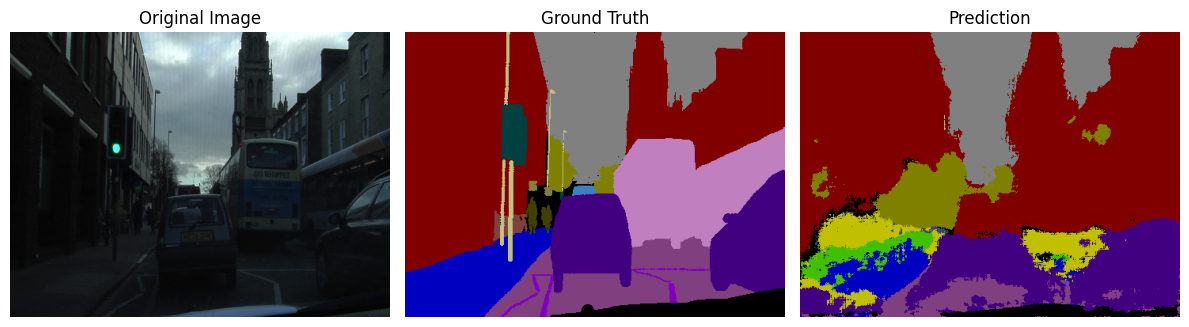

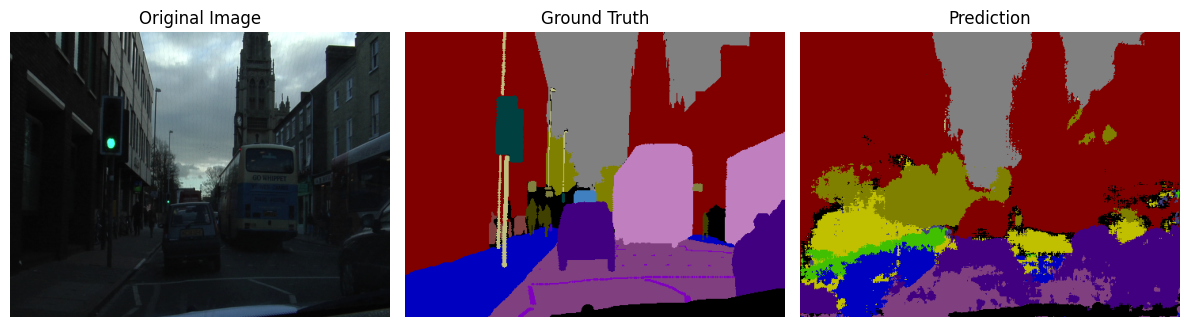

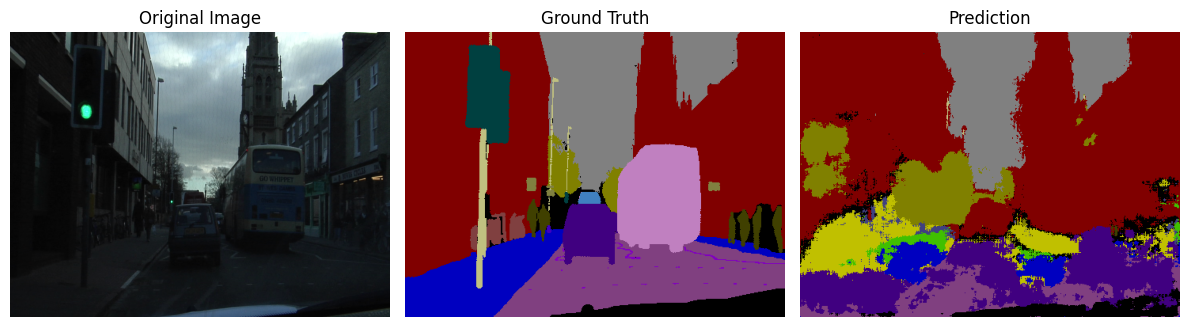

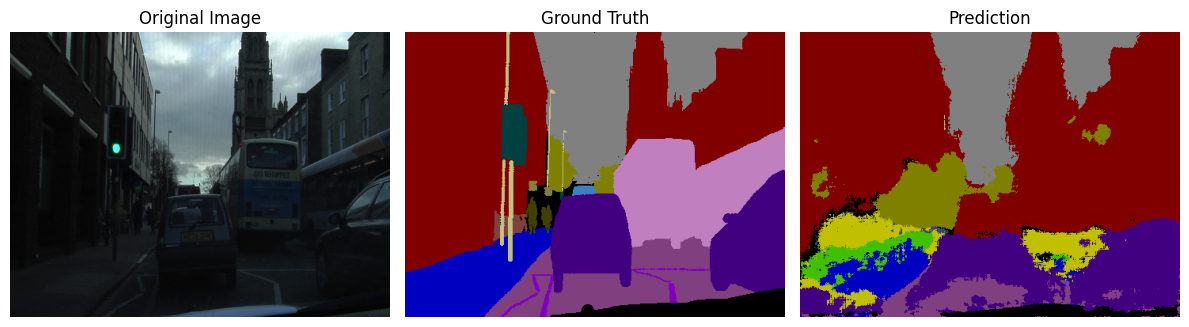

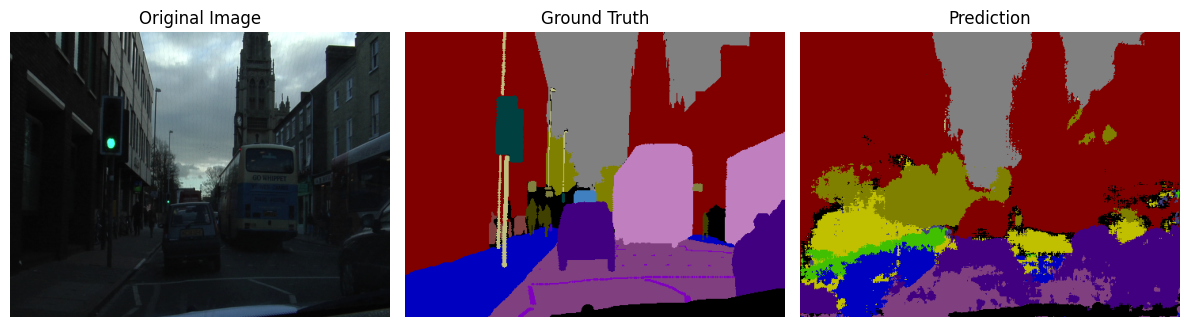

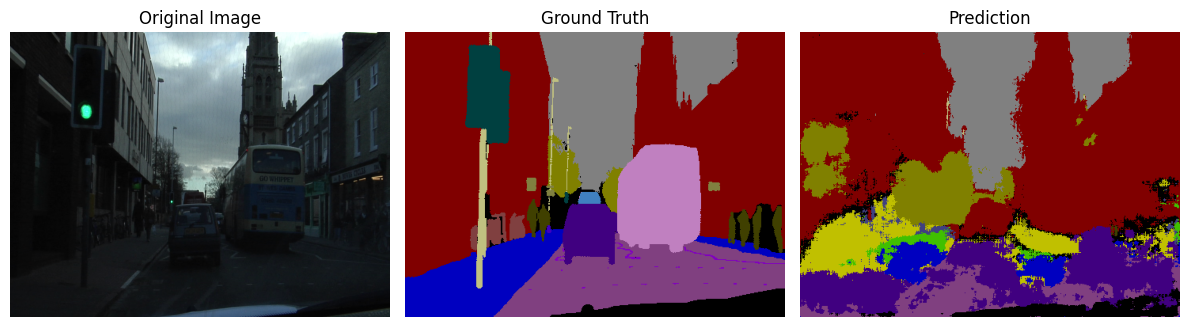

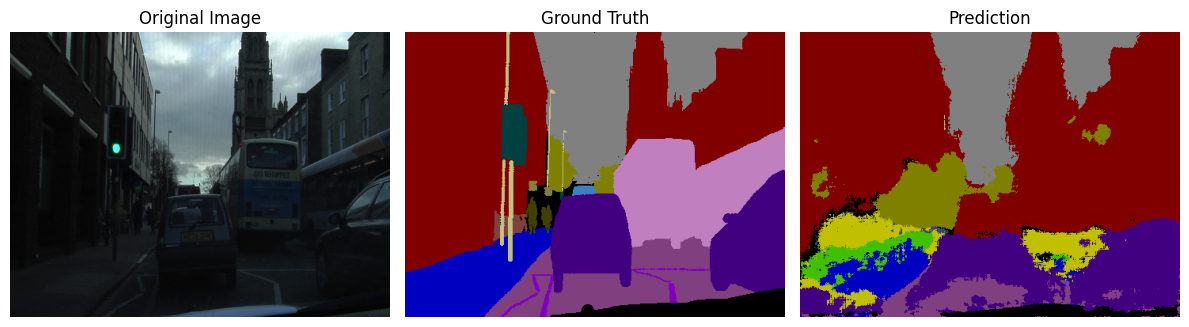

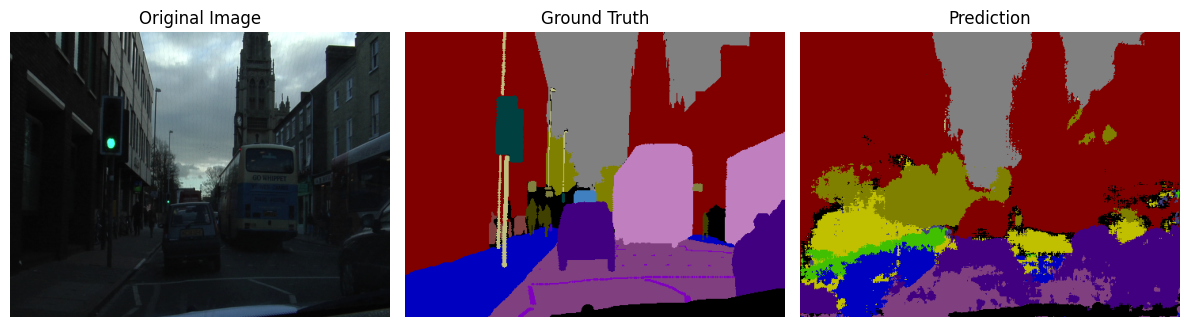

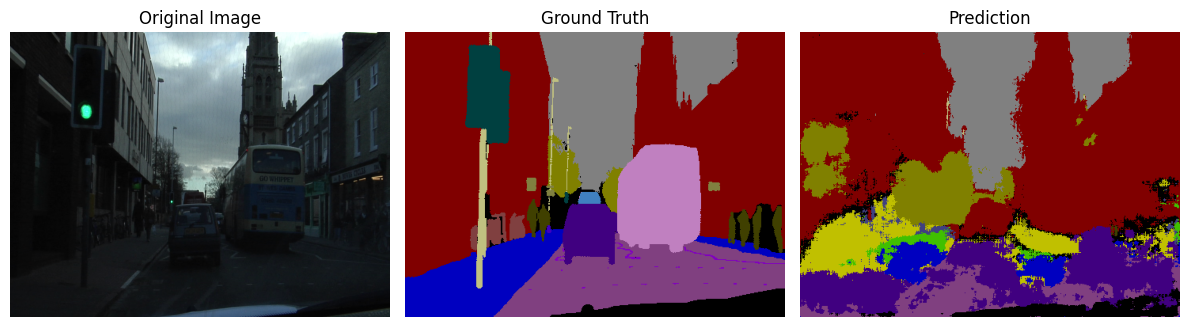

In [21]:
three_classes = [2, 1, 6]  # e.g. "Car", "Some-other", "Pedestrian" (just an example)
for cls_id in three_classes:
    count_vis = 0
    for i in range(len(all_preds)):
        iou_val = iou_for_single_class(all_preds[i], all_targets[i], cls_id)
        if iou_val <= 0.5:
            # 1) Obtain the original image filename
            img_name = test_dataset.image_names[i]
            img_path = os.path.join(test_dataset.images_dir, img_name)
            
            # 2) Open as PIL
            original_img = Image.open(img_path).convert("RGB")
            
            # 3) Visualize
            visualize_segmentation(original_img, all_preds[i], all_targets[i], color_map)
            
            count_vis += 1
            if count_vis == 3:
                break



We see the IoU is low for these samples likely because the object is heavily occluded (first image). In the second image, the ‘Car’ merges with the background color. The third image might have a partial viewpoint or unusual angle. Possibly the model confuses it with the ‘Truck’ class due to similar shape or color.

<h3> <b> Part 3

In [5]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision.models.segmentation import deeplabv3_resnet50
import numpy as np
from sklearn.metrics import confusion_matrix

class DeepLabV3:
    def __init__(self, num_classes=32):
        # Initialize wandb
        wandb.init(project="deeplabv3-camvid", name="fine-tuning")
        
        # Download and load pre-trained DeepLabV3
        print("Downloading pre-trained DeepLabV3 model...")
        self.model = deeplabv3_resnet50(weights=torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
        print("Model downloaded successfully!")
        
        # Modify the classifier for CamVID classes
        self.model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))
        
        # Move model to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.model = self.model.to(self.device)
        
        # Define loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        
    def train_step(self, images, labels):
        self.model.train()
        self.optimizer.zero_grad()
        
        # Forward pass
        outputs = self.model(images)['out']
        loss = self.criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train(self, train_loader, num_epochs=10):
        print("Starting training...")
        for epoch in range(num_epochs):
            train_loss = 0.0
            num_batches = len(train_loader)
            
            with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
                for images, labels in pbar:
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    
                    batch_loss = self.train_step(images, labels)
                    train_loss += batch_loss
                    
                    # Update progress bar
                    pbar.set_postfix({'loss': batch_loss})
            
            # Calculate average loss for the epoch
            avg_train_loss = train_loss / num_batches
            
            # Log metrics to wandb
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
            })
            
            print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}')
            
            # Save model checkpoint
            if (epoch + 1) % 5 == 0:
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': avg_train_loss,
                }, f'checkpoint_epoch_{epoch+1}.pth')
                
    def evaluate_testset(self, test_loader, num_classes=32):
        """
        Gathers predictions on the test set, computes pixel-wise metrics:
          - Pixel Accuracy
          - Classwise IoU & mIoU
          - Classwise Dice
          - Classwise Precision, Recall
          - Binning IoUs in [0,1] with 0.1 intervals
        """
        self.model.eval()
        
        all_preds = []
        all_labels = []

        # 1) Gather predictions & ground truth
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)['out']
                preds = torch.argmax(outputs, dim=1)  # [B,H,W]
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        all_preds = np.array(all_preds)   # shape [N, H, W]
        all_labels = np.array(all_labels) # shape [N, H, W]

        # Flatten them to compute a combined confusion matrix
        # We'll ignore any special 'void' index if you have that in your dataset
        # For simplicity, assume all_labels in [0..num_classes-1].
        flat_preds = all_preds.reshape(-1)
        flat_labels = all_labels.reshape(-1)

        # 2) Construct confusion matrix => shape [num_classes, num_classes]
        conf_mat = confusion_matrix(flat_labels, flat_preds, labels=range(num_classes))

        # 3) Compute metrics from confusion matrix
        pixel_acc = conf_mat.trace() / conf_mat.sum()

        # Classwise stats
        class_iou = np.zeros(num_classes)
        class_dice = np.zeros(num_classes)
        class_prec = np.zeros(num_classes)
        class_recall = np.zeros(num_classes)

        for c in range(num_classes):
            TP = conf_mat[c, c]
            FP = conf_mat[:, c].sum() - TP
            FN = conf_mat[c, :].sum() - TP
            # TN = conf_mat.sum() - (TP+FP+FN) # rarely needed

            denom_iou = (TP + FP + FN)
            class_iou[c] = TP / denom_iou if denom_iou>0 else np.nan

            denom_dice = (2*TP + FP + FN)
            class_dice[c] = (2*TP)/denom_dice if denom_dice>0 else np.nan

            denom_prec = (TP + FP)
            class_prec[c] = TP/denom_prec if denom_prec>0 else np.nan

            denom_rec = (TP + FN)
            class_recall[c] = TP/denom_rec if denom_rec>0 else np.nan

        mIoU = np.nanmean(class_iou)

        print("=== DeepLabV3 Test Set Performance ===")
        print(f"Pixel Accuracy: {pixel_acc:.4f}")
        print(f"mIoU: {mIoU:.4f}\n")

        for c in range(num_classes):
            print(f"Class {c}: "
                  f"IoU={class_iou[c]:.3f}, "
                  f"Dice={class_dice[c]:.3f}, "
                  f"Prec={class_prec[c]:.3f}, "
                  f"Recall={class_recall[c]:.3f}")
        print("=======================================")

        # 4) Bin IoUs in [0,1] with 0.1 intervals
        bin_edges = np.linspace(0,1,11)  # 0.0..0.1..1.0
        hist, _ = np.histogram(class_iou, bins=bin_edges)
        for i in range(len(hist)):
            print(f"Classes with IoU in [{bin_edges[i]:.1f}, {bin_edges[i+1]:.1f}): {hist[i]}")
        
        # Return or store metrics for further usage
        return {
            'pixel_acc': pixel_acc,
            'class_iou': class_iou,
            'mIoU': mIoU,
            'class_dice': class_dice,
            'class_prec': class_prec,
            'class_recall': class_recall
        }

In [6]:
import torchvision.transforms.functional as F
trainer = DeepLabV3(num_classes=32) 
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, drop_last=True)
trainer.train(train_loader)

wandb: Currently logged in as: kartikeydhaka (kartikey_dhaka) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Model downloaded successfully!
Using device: cuda
Starting training...


Epoch 1/10: 100%|██████████| 92/92 [00:45<00:00,  2.01it/s, loss=1.1] 


Epoch 1: Train Loss = 1.6982


Epoch 2/10: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.86] 


Epoch 2: Train Loss = 0.9391


Epoch 3/10: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.936]


Epoch 3: Train Loss = 0.7094


Epoch 4/10: 100%|██████████| 92/92 [00:45<00:00,  2.03it/s, loss=0.523]


Epoch 4: Train Loss = 0.5665


Epoch 5/10: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.356]


Epoch 5: Train Loss = 0.4726


Epoch 6/10: 100%|██████████| 92/92 [00:45<00:00,  2.03it/s, loss=0.377]


Epoch 6: Train Loss = 0.4010


Epoch 7/10: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.282]


Epoch 7: Train Loss = 0.3530


Epoch 8/10: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.31] 


Epoch 8: Train Loss = 0.3153


Epoch 9/10: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.266]


Epoch 9: Train Loss = 0.2786


Epoch 10/10: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s, loss=0.244]


Epoch 10: Train Loss = 0.2526


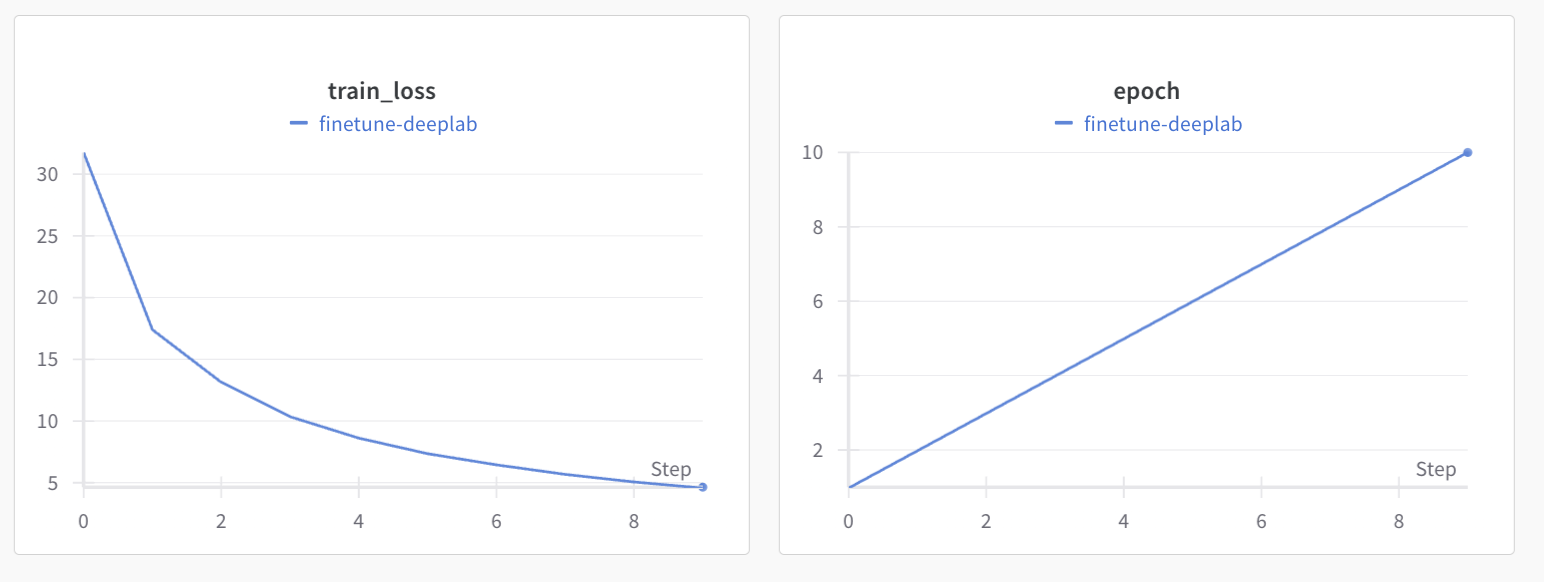

In [7]:
metrics = trainer.evaluate_testset(test_loader, num_classes=32)

=== DeepLabV3 Test Set Performance ===
Pixel Accuracy: 0.8782
mIoU: 0.3774

Class 0: IoU=0.000, Dice=0.000, Prec=nan, Recall=0.000
Class 1: IoU=0.000, Dice=0.000, Prec=nan, Recall=0.000
Class 2: IoU=0.554, Dice=0.713, Prec=0.874, Recall=0.602
Class 3: IoU=0.000, Dice=0.000, Prec=nan, Recall=0.000
Class 4: IoU=0.842, Dice=0.914, Prec=0.876, Recall=0.957
Class 5: IoU=0.790, Dice=0.883, Prec=0.833, Recall=0.938
Class 6: IoU=0.000, Dice=0.000, Prec=nan, Recall=0.000
Class 7: IoU=0.000, Dice=0.000, Prec=nan, Recall=0.000
Class 8: IoU=0.177, Dice=0.301, Prec=0.442, Recall=0.228
Class 9: IoU=0.549, Dice=0.709, Prec=0.819, Recall=0.625
Class 10: IoU=0.386, Dice=0.557, Prec=0.617, Recall=0.507
Class 11: IoU=0.000, Dice=0.000, Prec=nan, Recall=0.000
Class 12: IoU=0.317, Dice=0.482, Prec=0.595, Recall=0.405
Class 13: IoU=0.000, Dice=0.000, Prec=nan, Recall=0.000
Class 14: IoU=0.391, Dice=0.562, Prec=0.745, Recall=0.451
Class 15: IoU=0.385, Dice=0.556, Prec=0.822, Recall=0.420
Class 16: IoU=0.426,

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

def iou_for_single_class(pred_mask, gt_mask, cls_id):
    """
    pred_mask, gt_mask: shape [H,W], each pixel in [0..num_classes-1]
    cls_id: int
    Return IoU for that class.
    """
    pred_c = (pred_mask == cls_id)
    gt_c   = (gt_mask == cls_id)
    intersection = np.logical_and(pred_c, gt_c).sum()
    union        = np.logical_or(pred_c, gt_c).sum()
    if union == 0:
        return 0.0
    return intersection / union

def color_encode_mask(mask_2d, color_map):
    """
    mask_2d: [H,W] integer class IDs
    color_map: e.g. list or array of shape [num_classes, 3], each row is (R,G,B)
    returns [H,W,3] color-coded image
    """
    h, w = mask_2d.shape
    color_mask = np.zeros((h,w,3), dtype=np.uint8)
    for c in range(len(color_map)):
        color_mask[mask_2d == c] = color_map[c]
    return color_mask

def visualize_segmentation(original_img, pred_mask, gt_mask, color_map):
    # original_img can be PIL or numpy
    # pred_mask, gt_mask => [H,W], color_map => [num_classes, 3]
    
    pred_color = color_encode_mask(pred_mask, color_map)
    gt_color   = color_encode_mask(gt_mask, color_map)

    fig, axs = plt.subplots(1,3, figsize=(12,5))
    
    if isinstance(original_img, Image.Image):
        axs[0].imshow(original_img)
    else:
        axs[0].imshow(original_img.astype(np.uint8))
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(gt_color)
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    axs[2].imshow(pred_color)
    axs[2].set_title("Prediction")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


(c)

In [ ]:
def visualize_hard_samples(model, test_dataset, all_preds, all_labels, color_map):

    classes_of_interest = [5, 10, 17]
    
    for cls_id in classes_of_interest:
        count_vis = 0
        
        for i in range(len(all_preds)):
            # compute IoU for single class
            iou_val = iou_for_single_class(all_preds[i], all_labels[i], cls_id)
            if iou_val <= 0.5:
                # 1) Retrieve original image from dataset
                # If your dataset provides (image_path = dataset.image_paths[i]) or so
                img_name = test_dataset.image_names[i]
                img_path = os.path.join(test_dataset.images_dir, img_name)
                original_img = Image.open(img_path).convert("RGB")
                
                # 2) Visualize
                visualize_segmentation(original_img, all_preds[i], all_labels[i], color_map)
                
                count_vis += 1
                if count_vis == 3:
                    break


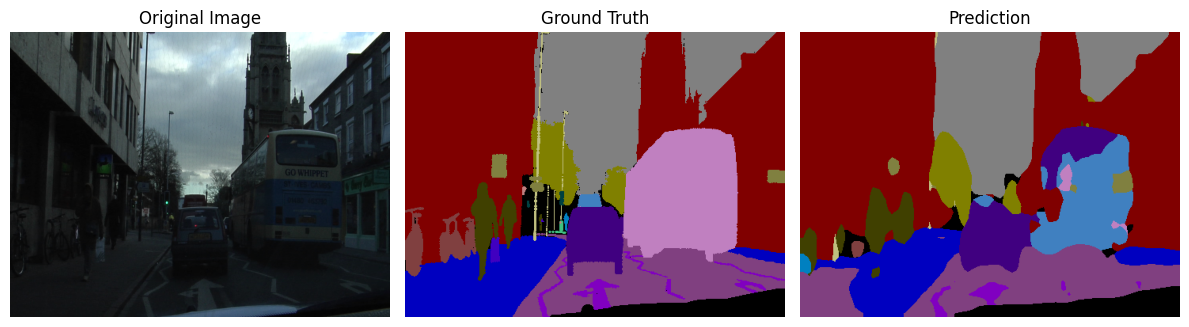

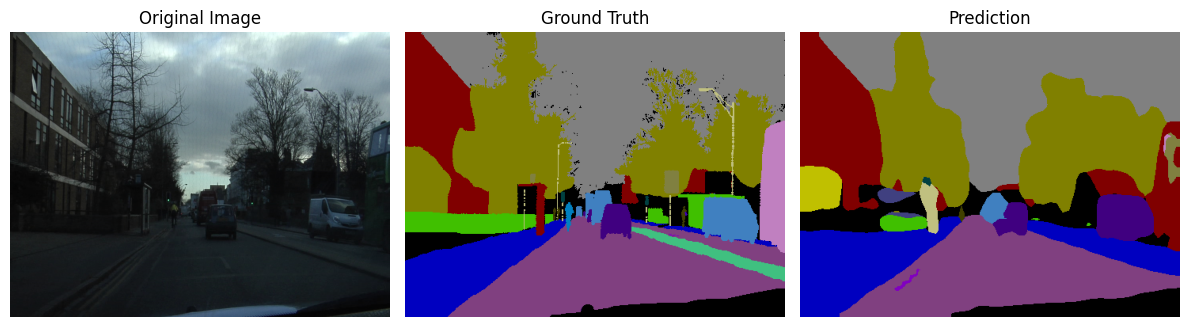

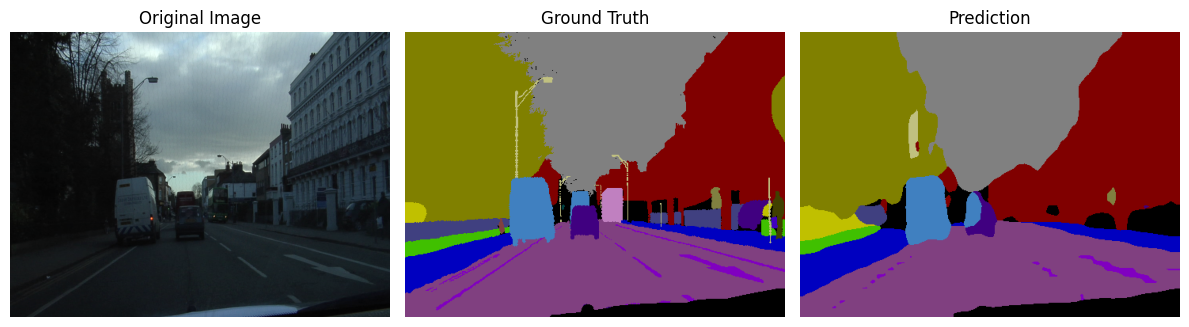

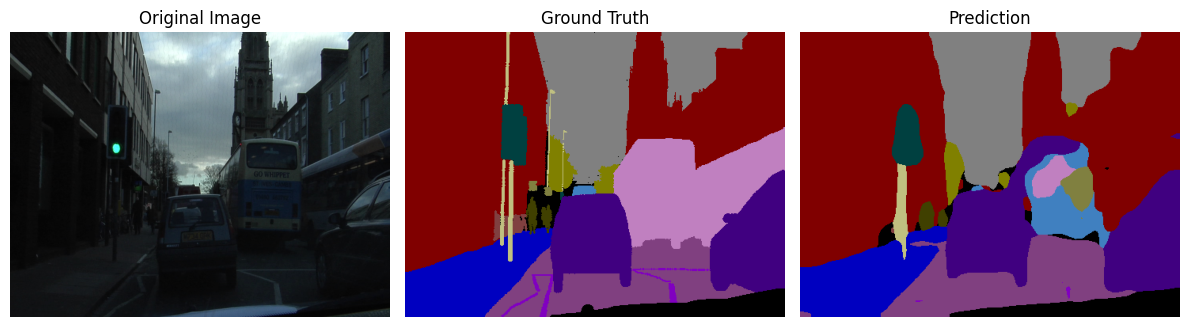

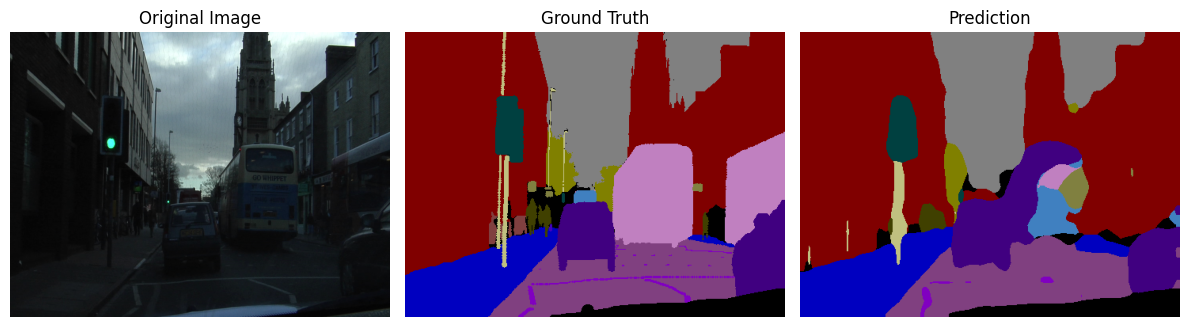

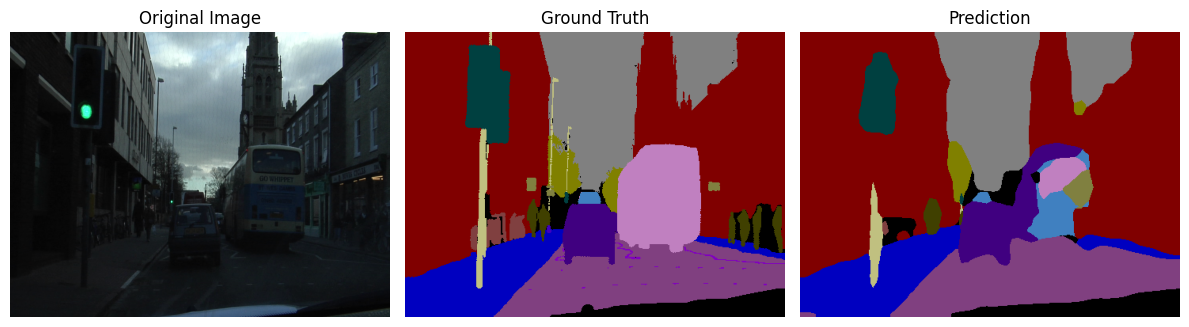

In [12]:

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(trainer.device)
        outputs = trainer.model(images)['out']
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


visualize_hard_samples(trainer, test_dataset, all_preds, all_labels, color_map)


possible failure reasons: 

Partial Occlusion:
The object may be partly hidden behind another object (or by its own parts), so the network cannot see its complete structure. This leads to lower IoU because only a portion of the object is detected.

Low Contrast/Similar Color to Background:
When the object’s color or texture is very similar to its surrounding background, the model may have difficulty distinguishing its boundaries. This is especially problematic in scenes with uniform or low-contrast lighting.

Small Object Size:
Small objects have fewer pixels to define their shape. Even a small misalignment can cause a dramatic drop in IoU. The network may also miss small objects entirely if they are underrepresented in training.

Motion Blur / low resolution:
If the object or camera is moving or the image is low resolution, the resulting blur can make object boundaries less distinct, leading to inaccurate predictions.

Unusual Poses or Deformations:
Objects presented in atypical orientations or deformed shapes (e.g., due to perspective distortion) can challenge the network if such variations were not well represented in the training data.

Lighting Variations:
Drastic changes in lighting conditions (overexposure, underexposure, shadows) can alter the appearance of an object. These changes may confuse the model, resulting in misclassification or inaccurate boundaries.

Scale Variations:
If the object appears at a scale significantly different from those seen during training, the model may struggle with proper localization, especially if it’s too small or too large relative to the image size.